# Dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

data_dir = "/content/drive/MyDrive/AI_Project/data/"

Mounted at /content/drive


In [ ]:
%%capture
!pip install spacy
!pip install spacy-dbpedia-spotlight
!pip install wikipedia
!pip install SPARQLWrapper
!pip install spacy-transformers 

In [ ]:
import spacy

from spacy.cli import download as spacy_download
import spacy_transformers
import wikipedia

from SPARQLWrapper import SPARQLWrapper, JSON
sparql = SPARQLWrapper("http://dbpedia.org/sparql")

from transformers import AutoTokenizer, TFAutoModelForQuestionAnswering
import tensorflow as tf

import pandas as pd
import json
from tqdm import tqdm
import time
import os

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
spacy_model = 'en_core_web_trf'
spacy_download(spacy_model)
ner = spacy.load(spacy_model)

try:
    ner.add_pipe('dbpedia_spotlight')
    ner.pipeline
except:
    print("pipeline already present")

tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
model = TFAutoModelForQuestionAnswering.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')


All model checkpoint layers were used when initializing TFBertForQuestionAnswering.

All the layers of TFBertForQuestionAnswering were initialized from the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForQuestionAnswering for predictions without further training.


# General Tasks

## Named Entity Recognition (NER)


In [ ]:
def entity_recognition(question):
    
    doc_spacy = ner(question) 

    # Ritorno entità trovate
    return doc_spacy.ents

## Named Entity Linking (NEL)


In [ ]:
def entity_linking(entities):

    if len(entities) == 0:
        return None

    df = pd.DataFrame(
        [(ent.text, ent.kb_id_, ent._.dbpedia_raw_result['@similarityScore']) for ent in entities],
        columns = ['mention', 'link', 'similarity']
    )
    if len(df) > 0:
        return df["link"][0]
    else:
        return None

## Answer Selection

In [ ]:
def answer_selection(question, context):
    inputs = tokenizer(question, context, add_special_tokens=True, return_tensors="tf",truncation=True)
    input_ids = inputs["input_ids"].numpy()[0]

    outputs = model(inputs)
    answer_start_scores = outputs.start_logits
    answer_end_scores = outputs.end_logits
        
    answer_start = tf.argmax(
        answer_start_scores, axis=1
    ).numpy()[0]  # Get the most likely beginning of answer with the argmax of the score
    answer_end = (
        tf.argmax(answer_end_scores, axis=1) + 1
    ).numpy()[0]  # Get the most likely end of answer with the argmax of the score
    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))
        
    # print(f"Question: {question}")
    # print(f"Answer: {answer}")

    return answer

# Knowledge Graphs Approach

## Relations Retrieval

In [ ]:
## Funzioni query al KG

# Relation from the entity
def relationFromEntity(entity):
	sparql.setQuery("PREFIX dbr: <http://dbpedia.org/resource/> \n" + 
	"SELECT ?propertyLabel (GROUP_CONCAT(DISTINCT ?valueLabel ; SEPARATOR=\", \") AS ?valueLabel ) {\n"+
		
		"<" + entity + """> ?property ?value .
		OPTIONAL {?property rdfs:comment ?auxProperty .}
		FILTER (!bound(?auxProperty ) || !strstarts(str(?auxProperty),
						str("Reserved for DBpedia")))
		FILTER (!strstarts( str(?property),
						str("http://dbpedia.org/ontology/abstract")))
		?property rdfs:label ?propertyLabel .
		FILTER (LANGMATCHES(LANG(?propertyLabel ), "en"))
		OPTIONAL {?value rdfs:label ?auxValue .}
		BIND (IF(isLiteral(?value), ?value, ?auxValue) AS ?valueLabel)
		FILTER (isNumeric(?valueLabel) || 
						LANGMATCHES(LANG(?valueLabel ), "en"))
	}
	""")

	sparql.setReturnFormat(JSON)
	return sparql.query().convert()


# Relation to the entity
def relationToEntity(entity):

	sparql.setQuery("PREFIX dbr: <http://dbpedia.org/resource/> \n" + 
	"SELECT ?propertyLabel (GROUP_CONCAT(DISTINCT ?valueLabel ; SEPARATOR=\", \") AS ?valueLabel ) {\n"+

		"?value ?property  <" + entity + """>.
		OPTIONAL {?property rdfs:comment ?auxProperty .}
		FILTER (!bound(?auxProperty ) || !strstarts(str(?auxProperty),
						str("Reserved for DBpedia")))
		FILTER (!strstarts( str(?property),
						str("http://dbpedia.org/ontology/abstract")))
		?property rdfs:label ?propertyLabel .
		FILTER (LANGMATCHES(LANG(?propertyLabel ), "en"))
		OPTIONAL {?value rdfs:label ?auxValue .}
		BIND (IF(isLiteral(?value), ?value, ?auxValue) AS ?valueLabel)
		FILTER (isNumeric(?valueLabel) || 
						LANGMATCHES(LANG(?valueLabel ), "en"))
	}
	""")

	sparql.setReturnFormat(JSON)
	return sparql.query().convert()

 


## Funzione: tripla KG a frase in linguaggio naturale
def query2Text(entity, results = None):
	text = ""
	if results != None:
		for result in results["results"]["bindings"]:
			text = text + entity +" has " + result["propertyLabel"]["value"].replace('\n', ' ').replace('\r', '') + ", that it is " + result["valueLabel"]["value"].replace('\n', ' ').replace('\r', '') + ". " + "\n"
	return text


In [ ]:
def get_relations(entities, entity):
    text = ""

    results = relationFromEntity(entity)
    text = text + query2Text(entities[0].text, results)     #primo input di query2Text() è stringa entità trovata al punto 1
            
    # Second direction
    text = text + "\n"+ "\n"

    results = relationToEntity(entity)
    text = text + query2Text(entities[0].text, results)

    return text

In [ ]:
def kg_pipeline(question):
    
    timings = {}
    
    t = time.time()
    entities = entity_recognition(question)
    timings["ner"] = time.time() - t

    t = time.time()
    entity = entity_linking(entities)
    timings["nel"] = time.time() - t
    
    t = time.time()
    relations_text = get_relations(entities, entity)
    timings["relations"] = time.time() - t

    t = time.time()
    answer = answer_selection(question, relations_text)
    timings["answer"] = time.time() - t

    return answer, timings

# Language Models Approach

## Abstract Retrieval

In [ ]:
# Prendo abstract da entità
def abstractFromEntity(entity):
	sparql.setQuery("""
prefix dbpedia: <http://dbpedia.org/resource/>
prefix dbpedia-owl: <http://dbpedia.org/ontology/>
select ?abstract where { 
  <"""+ entity +"""> dbpedia-owl:abstract ?abstract ;
                                         dbpedia-owl:thumbnail ?thumbnail .
filter(langMatches(lang(?abstract),"en"))
}
  """)

	sparql.setReturnFormat(JSON)
	return sparql.query().convert()
 
def abstract2Text(results = None):
	text = ""
	if results != None:
		for result in results["results"]["bindings"]:
			text = text + result["abstract"]["value"].replace('\n', ' ').replace('\r', '') 
	return text

In [ ]:
def lm_pipeline(question):

    timings = {}
    
    t = time.time()
    entities = entity_recognition(question)
    timings["ner"] = time.time() - t

    t = time.time()
    entity = entity_linking(entities)
    timings["nel"] = time.time() - t

    t = time.time()
    abstract = abstractFromEntity(entity)
    abstract = abstract2Text(abstract)
    timings["abstract"] = time.time() - t
    
    t = time.time()
    answer = answer_selection(question, abstract)
    timings["answer"] = time.time() - t

    return answer, timings

# KG+LM Integration

In [ ]:
def kglm_pipeline(question):

    timings = {}
    
    t = time.time()
    entities = entity_recognition(question)
    timings["ner"] = time.time() - t

    t = time.time()
    entity = entity_linking(entities)
    timings["nel"] = time.time() - t

    t = time.time()
    relations_text = get_relations(entities, entity)
    timings["relations"] = time.time() - t

    t = time.time()
    abstract = abstractFromEntity(entity)
    abstract = abstract2Text(abstract)
    timings["abstract"] = time.time() - t
    
    context = relations_text + abstract

    t = time.time()
    answer = answer_selection(question, context)
    timings["answer"] = time.time() - t

    return answer, timings

# Ask Manual Questions

In [ ]:
def print_timings(timings):
    for key in timings:
        print(f"{key} time:\t{timings[key]}")
    
    print("Total time:\t", sum(timings.values()))

In [ ]:
# Ricaviamo le entità
question1 = """ max verstappen is the actual formula 1 world champion, maybe the next season charles leclrec could beat him.
max is like a rockstar in netherlands.
i like so much formula 1 is a great sport with a lot of strategy.  
"""

question2 = "who is fernando alonso father?"

question3 = "What is the birthplace of the author of Harry Potter?"

question4 = "Rashid Behbudov State Song Theatre and Baku Puppet Theatre can be found in which country?"

question5 = "What is the lake of the city of Lecco?"

question6 = "what genres does the live aid concert encompass?"

question7 = "Which club did Maradona play for?"

question8 = "where is born michael jackson?"

In [ ]:
question = question7
print("Question: ", question)

answer, kg_timings = kg_pipeline(question)
print("\nAnswer from KG:", answer)
print("KG timings:")
print_timings(kg_timings)


answer, lm_timings = lm_pipeline(question)
print("\nAnswer from LMs:", answer)
print("LM timings:")
print_timings(lm_timings)

answer, kglm_timings = kglm_pipeline(question)
print("\nAnswer from both KG+LM:", answer)
print("KG+LM timings:")
print_timings(kglm_timings)

Question:  Which club did Maradona play for?

Answer from KG: argentinos juniors
KG timings:
ner time:	0.9091362953186035
nel time:	0.009644269943237305
relations time:	2.0161569118499756
answer time:	13.344043970108032
Total time:	 16.27898144721985

Answer from LMs: barcelona
LM timings:
ner time:	0.552722692489624
nel time:	0.0013310909271240234
abstract time:	0.545689582824707
answer time:	9.287620782852173
Total time:	 10.387364149093628

Answer from both KG+LM: argentinos juniors
KG+LM timings:
ner time:	0.8143775463104248
nel time:	0.010827064514160156
relations time:	1.0973644256591797
abstract time:	0.5382494926452637
answer time:	7.9347920417785645
Total time:	 10.395610570907593


# Benchmark Tests

## Predicate Recognition

In [ ]:
val_path = data_dir + "SimpleDBPediaQA/" + "valid.json"

val_file = open(val_path)
val_dict = json.load(val_file)
val_file.close()

In [ ]:
len(val_dict["Questions"])

4305

In [ ]:
%%script false --no-raise-error

correct = 0

for doc in tqdm(val_dict["Questions"]):
    question = doc["Query"]

    try:
        entities = entity_recognition(question)
        entity = entity_linking(entities)
    except:
        continue
    
    if entity == doc["Subject"]:
        correct = correct+1

accuracy = correct / len(val_dict["Questions"])
print("Subject Recognition accuracy: ", accuracy)

In [ ]:
print("Subject Recognition accuracy: 0.5163763066202091")

Subject Recognition accuracy: 0.5163763066202091


## Question Answering

In [ ]:
questions_df = pd.read_csv(data_dir+"questions_benchmark.csv")
questions_df.head()

,question,expected_answer
0,Where did Barack obama Graduate?,
1,Where was Barack Obama born?,
2,Who is barack Obama’s wife?,
3,When was barack obama elected as president of ...,
4,who was the predecessor of barack obama?,


In [ ]:
def sum_timings(total, current):
    for key in current:
        total[key] += current[key]

    total["count"] +=1

    return total

In [ ]:
questions_benchmark_path = data_dir+"questions_benchmark_answered.csv"

if os.path.exists(questions_benchmark_path):
    questions_df = pd.read_csv(questions_benchmark_path)

else:
    kg_total_timings = {"ner":0, "nel":0, "relations":0, "answer":0, "count":0}
    lm_total_timings = {"ner":0, "nel":0, "abstract":0, "answer":0, "count":0}
    kglm_total_timings = {"ner":0, "nel":0, "relations":0, "abstract":0, "answer":0, "count":0}

    kg_answers = []
    lm_answers = []
    kglm_answers = []

    for question in tqdm(questions_df["question"]):

        try:
            kg_answer, kg_timings = kg_pipeline(question)
            kg_answers.append(kg_answer)
            kg_total_timings = sum_timings(kg_total_timings, kg_timings)
        except:
            kg_answers.append("")

        try:
            lm_answer, lm_timings = lm_pipeline(question)
            lm_answers.append(lm_answer)
            lm_total_timings = sum_timings(lm_total_timings, lm_timings)
        except:
            lm_answers.append("")

        try:
            kglm_answer, kglm_timings = kglm_pipeline(question)
            kglm_answers.append(kglm_answer)
            kglm_total_timings = sum_timings(kglm_total_timings, kglm_timings)
        except:
            kglm_answers.append("")

    questions_df["kg_answers"] = kg_answers
    questions_df["lm_answers"] = lm_answers
    questions_df["kglm_answers"] = kglm_answers

    questions_df.to_csv(questions_benchmark_path)

    with open(data_dir+"timings/kg_timings.json", "w") as write_file:
        json.dump(kg_total_timings, write_file, indent=4)

    with open(data_dir+"timings/lm_timings.json", "w") as write_file:
        json.dump(lm_total_timings, write_file, indent=4)

    with open(data_dir+"timings/kglm_timings.json", "w") as write_file:
        json.dump(kglm_total_timings, write_file, indent=4)

questions_df.head()

,question,expected_answer,kg_answers,kg_labels,lm_answers,lm_labels,kglm_answers,kglm_labels
0,Where did Barack obama Graduate?,,"columbia university, harvard law school",2,columbia university,2,columbia university,2
1,Where was Barack Obama born?,,[CLS],-1,"honolulu, hawaii",2,"honolulu, hawaii",2
2,Who is barack Obama’s wife?,,[CLS],-1,hillary clinton,0,hillary clinton,0
3,When was barack obama elected as president of ...,,[CLS],-1,2008,2,2008,2
4,who was the predecessor of barack obama?,,alice palmer,2,barack hussein obama ii,1,barack hussein obama ii,1


In [ ]:
if "kg_labels" not in questions_df.columns:
    
    zeros = [0] * 50
    questions_df["kg_labels"] = zeros
    questions_df["lm_labels"] = zeros
    questions_df["kglm_labels"] = zeros

    questions_df = questions_df[['question', ' expected_answer', 'kg_answers', 'kg_labels', 'lm_answers', 'lm_labels', 'kglm_answers', 'kglm_labels']]

    questions_df.to_csv(data_dir+"questions_benchmark_answered.csv", index=False)

questions_df.head()

,question,expected_answer,kg_answers,kg_labels,lm_answers,lm_labels,kglm_answers,kglm_labels
0,Where did Barack obama Graduate?,,"columbia university, harvard law school",2,columbia university,2,columbia university,2
1,Where was Barack Obama born?,,[CLS],-1,"honolulu, hawaii",2,"honolulu, hawaii",2
2,Who is barack Obama’s wife?,,[CLS],-1,hillary clinton,0,hillary clinton,0
3,When was barack obama elected as president of ...,,[CLS],-1,2008,2,2008,2
4,who was the predecessor of barack obama?,,alice palmer,2,barack hussein obama ii,1,barack hussein obama ii,1


### Results Analysis

In [ ]:
summary_df = pd.DataFrame([], columns=["model", "not_found", "wrong", "acceptable", "correct"])
summary_df.loc[0] = ["KG", list(questions_df["kg_labels"]).count(-1), 
                     list(questions_df["kg_labels"]).count(0), 
                     list(questions_df["kg_labels"]).count(1), 
                     list(questions_df["kg_labels"]).count(2)]

summary_df.loc[1] = ["LM", list(questions_df["lm_labels"]).count(-1), 
                    list(questions_df["lm_labels"]).count(0), 
                    list(questions_df["lm_labels"]).count(1), 
                    list(questions_df["lm_labels"]).count(2)]

summary_df.loc[2] = ["KG+LM", list(questions_df["kglm_labels"]).count(-1), 
                    list(questions_df["kglm_labels"]).count(0), 
                    list(questions_df["kglm_labels"]).count(1), 
                    list(questions_df["kglm_labels"]).count(2)]
summary_df

,model,not_found,wrong,acceptable,correct
0,KG,13,4,7,26
1,LM,6,4,3,37
2,KG+LM,6,1,4,39


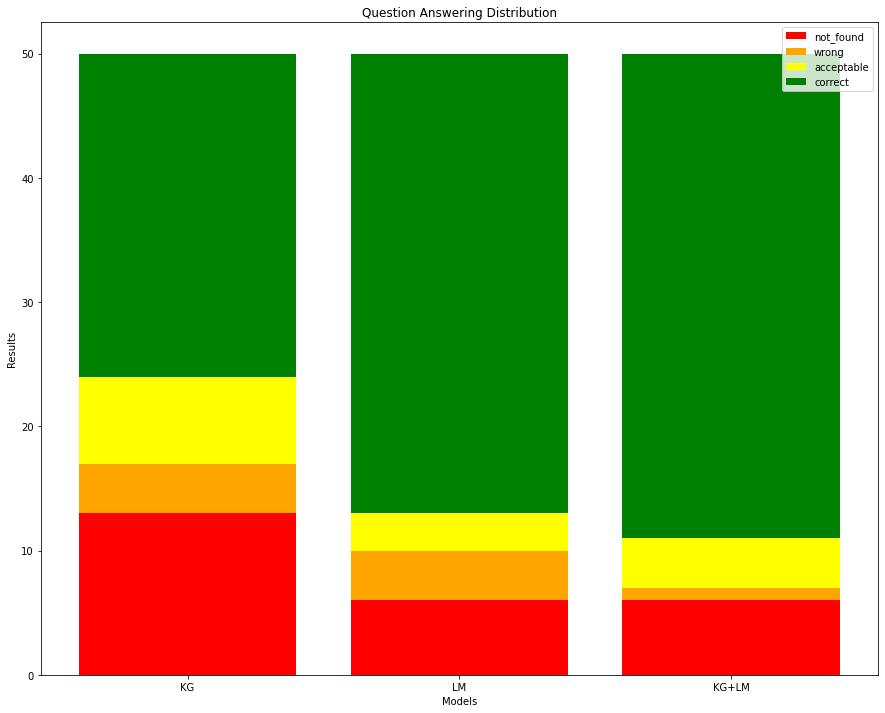

In [ ]:
import numpy as np

N = 3
ind = np.arange(N) # the x locations for the groups
# width = 0.35

fig = plt.figure(figsize=(15,12))
plt.bar(ind, summary_df["not_found"], color='r')
plt.bar(ind, summary_df["wrong"],bottom=summary_df["not_found"], color='orange')
plt.bar(ind, summary_df["acceptable"],bottom=summary_df["not_found"]+summary_df["wrong"], color='yellow')
plt.bar(ind, summary_df["correct"],bottom=summary_df["not_found"]+summary_df["wrong"]+summary_df["acceptable"], color='g')

plt.xlabel('Models')
plt.ylabel('Results')
plt.title('Question Answering Distribution')
plt.xticks(ind, ('KG', 'LM', 'KG+LM'))
plt.yticks(np.arange(0, 51, 10))

plt.legend(labels=['not_found', 'wrong', 'acceptable', 'correct'])
plt.savefig(data_dir+"figs/qa_results.png")
plt.show()

### Timings Analysis

In [ ]:
# Load data

f = open(data_dir+"timings/kg_timings.json")
kg_total_timings = json.load(f)

f = open(data_dir+"timings/lm_timings.json")
lm_total_timings = json.load(f)

f = open(data_dir+"timings/kglm_timings.json")
kglm_total_timings = json.load(f)

In [ ]:
def avg_timings(total):
    N = total["count"]
    avgs =  {key: value / N for key, value in total.items()}
    avgs.pop('count', None)

    return avgs

In [ ]:
kg_avg_timings = avg_timings(kg_total_timings)
lm_avg_timings = avg_timings(lm_total_timings)
kglm_avg_timings = avg_timings(kglm_total_timings)

[0.5347245877439325, 0.0017456358129327948, 1.4519440206614407, 12.164745124903591] 14.153159369121898
[3.78, 0.01, 10.26, 85.95]


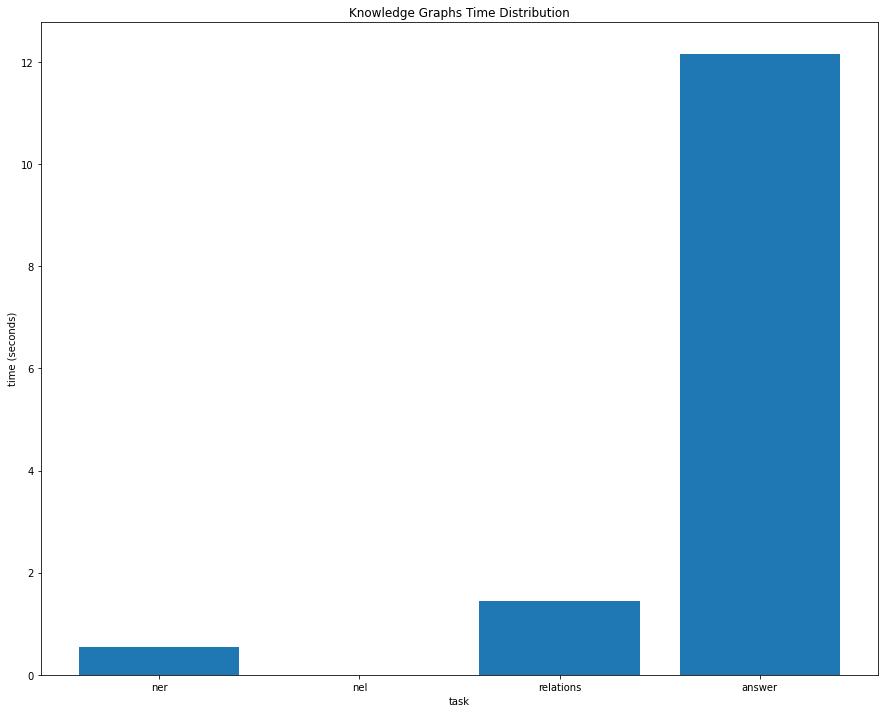

In [ ]:
import matplotlib.pyplot as plt

percentages = [round(x/sum(kg_avg_timings.values())*100,2) for x in kg_avg_timings.values()]
print(list(kg_avg_timings.values()), sum(kg_avg_timings.values()))
print(percentages)

fig = plt.figure(figsize=(15,12))
plt.bar(kg_avg_timings.keys(),kg_avg_timings.values())
# plt.yscale("log")

plt.title("Knowledge Graphs Time Distribution")
plt.xlabel("task")
plt.ylabel("time (seconds)")

plt.savefig(data_dir+"figs/kg_timings.png")
plt.show()

[0.5371917052702471, 0.0017472559755498712, 0.6589465899900957, 9.223882360891862] 10.421767912127756
[5.15, 0.02, 6.32, 88.51]


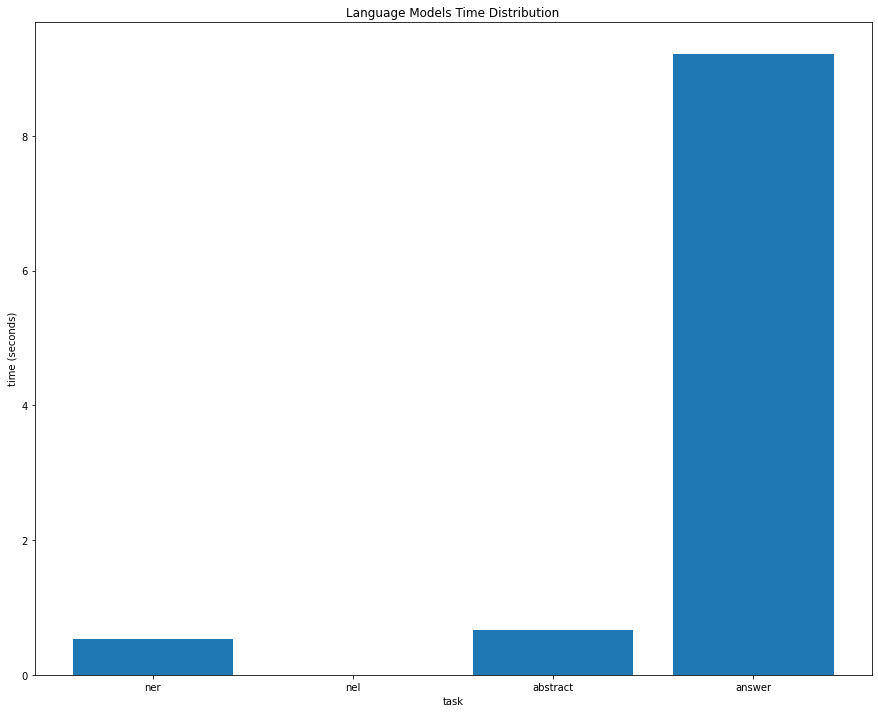

In [ ]:
percentages = [round(x/sum(lm_avg_timings.values())*100,2) for x in lm_avg_timings.values()]
print(list(lm_avg_timings.values()), sum(lm_avg_timings.values()))
print(percentages)

fig = plt.figure(figsize=(15,12))
plt.bar(lm_avg_timings.keys(),lm_avg_timings.values())
# plt.yscale("log")

plt.title("Language Models Time Distribution")
plt.xlabel("task")
plt.ylabel("time (seconds)")

plt.savefig(data_dir+"figs/lm_timings.png")
plt.show()

[0.5478735674511303, 0.0018295699899846857, 1.661735106598247, 0.7230384729125283, 12.133389857682316] 15.067866574634206
[3.64, 0.01, 11.03, 4.8, 80.52]


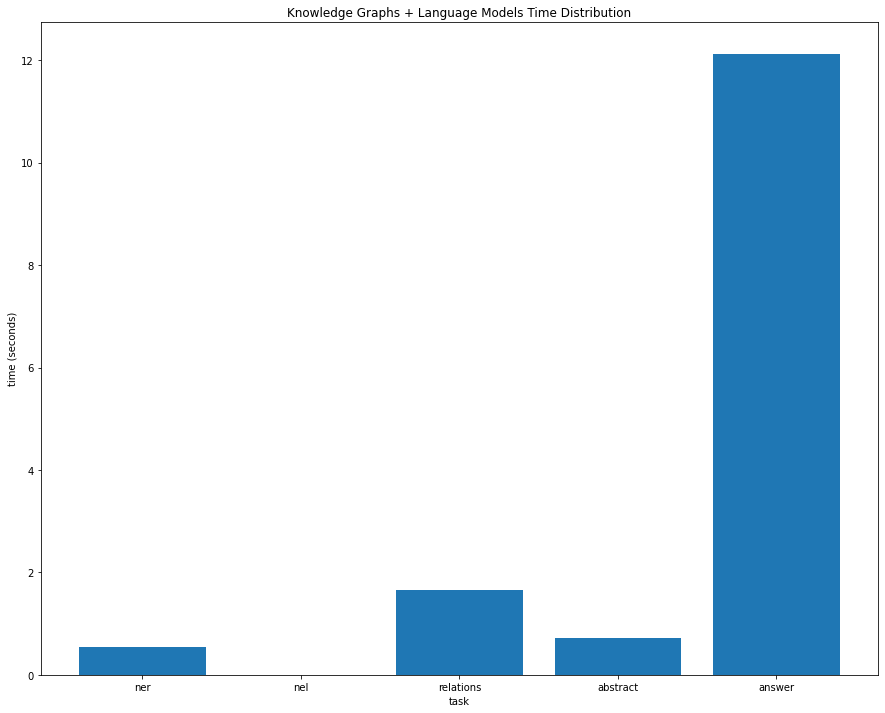

In [ ]:
percentages = [round(x/sum(kglm_avg_timings.values())*100,2) for x in kglm_avg_timings.values()]
print(list(kglm_avg_timings.values()), sum(kglm_avg_timings.values()))
print(percentages)

fig = plt.figure(figsize=(15,12))
plt.bar(kglm_avg_timings.keys(),kglm_avg_timings.values())
# plt.yscale("log")

plt.title("Knowledge Graphs + Language Models Time Distribution")
plt.xlabel("task")
plt.ylabel("time (seconds)")

plt.savefig(data_dir+"figs/kglm_timings.png")
plt.show()